# Selective Capacitated Fair Pickup and Delivery Problem

We start by importing all necessary modules

In [49]:
from dataclasses import dataclass
import math
from random import random
from collections import deque
import csv
import time
import pandas as pd
import os, glob
from tqdm import tqdm


import matplotlib.pyplot as plt
import random
random.seed(1090)

## Defining an "Instance" class
we start by defining a "Instance" class that contains all the information we are given from an instance file. We can access the variables for each instance as attributes of our "Instance" class. This is the data strucutre our algorithms will act upon

In [2]:
@dataclass
class Instance:
    def __init__(self, filename: str | None = None):
        if filename is not None:
            self.load_from_file(filename)

    @staticmethod # tell python this method doesn't depend on "self"
    def read_tuple(f):
        return tuple(map(int, f.readline().split()))

    def load_from_file(self, filename):
        with open(filename) as input_file:
            params_line = input_file.readline().split(" ")
            self.n = int(params_line[0])
            self.n_k = int(params_line[1])
            self.C = int(params_line[2])
            self.gamma = int(params_line[3])
            self.rho = float(params_line[4])
            _ = input_file.readline()
            demand_line = [int(c_i) for c_i in input_file.readline().split()]
            _ = input_file.readline()
            self.depot = self.read_tuple(input_file)
            self.requests = []
            self.requests_location_array = []
            for i in range(self.n):
                pick_up = self.read_tuple(input_file)
                request = {
                    "pick_up": pick_up,
                    "drop_off": None,
                    "demand": demand_line[i],
                    "index": i + 1 # because they start with one (not zero) in the assignment
                }
                self.requests.append(request)
                self.requests_location_array.append(pick_up)
            for i in range(self.n):
                drop_off = self.read_tuple(input_file)
                self.requests[i]["drop_off"] = drop_off
                self.requests_location_array.append(drop_off)
            if input_file.readline().strip() != "":# make sure we are at the end of the file and there's no more content
                raise ValueError("Unexpected extra content at end of file")

In [50]:
# testing how the class works
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
aaa = Instance()
aaa.load_from_file(filename)
aaa.depot

(50, 50)

## Helper Functions for evaluating the performance of our algorithm

In [51]:
# takes two tuples representing carthesian coordinates as input
def a(u, v):
    return math.ceil(math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2))

# takes the route as list of indices of request locations as input
def get_total_distance(instance, route):
    total_distance = 0
    current_location = instance.depot # we start at the depot
    for location_index in route:
        location_index = location_index - 1 # be careful with off-by-one errors!
        next_location = instance.requests_location_array[location_index]
        total_distance = total_distance + a(current_location, next_location)
        current_location = next_location
    total_distance = total_distance + a(current_location, instance.depot)
    return total_distance

# take a list of routes as input
def get_Jain_fairness(instance, routes):
    numerator = 0
    denominator = 0
    for route in routes:
        d = get_total_distance(instance, route)
        numerator = numerator + d
        denominator = denominator + d**2
    return numerator**2 / (instance.n_k * denominator) # I know it says n in the assignment but n_k makes more sense and its like that on wikipedia

def objective_function(instance, routes):
    value = 0
    for route in routes:
        value = value + get_total_distance(instance, route)
    value = value + instance.rho * (1 - get_Jain_fairness(instance, routes))
    return value

# used for delta evaluation later on
def delta_objective(instance, old_routes, new_routes):
    changed = []
    for i, (r_old, r_new) in enumerate(zip(old_routes, new_routes)):
        if r_old != r_new:
            changed.append(i)

    d_old = []
    d_new = []
    for i in changed:
        d_old.append(get_total_distance(instance, old_routes[i]))
        d_new.append(get_total_distance(instance, new_routes[i]))

    delta_dist = sum(d_new) - sum(d_old)

    # Old aggregated sums
    old_all_dist = []
    for r in old_routes:
        old_all_dist.append(get_total_distance(instance, r))
    old_sum = sum(old_all_dist)
    old_sum_sq = sum(d * d for d in old_all_dist)

    # New aggregated sums (update only the changed routes)
    new_all_dist = old_all_dist.copy()
    for i, idx in enumerate(changed):
        new_all_dist[idx] = d_new[i]    # replace old distance with new

    new_sum = sum(new_all_dist)
    new_sum_sq = sum(d * d for d in new_all_dist)

    fairness_old = (old_sum * old_sum) / (instance.n_k * old_sum_sq)
    fairness_new = (new_sum * new_sum) / (instance.n_k * new_sum_sq)

    delta_fairness = instance.rho * ((1 - fairness_new) - (1 - fairness_old))

    return delta_dist + delta_fairness

## Visualization
In order to get a better feeling what our algorithm is actually doing, here is a small visualization (Code generated with ChatGPT)

In [52]:
def plot_routes(instance, routes):
    plt.figure(figsize=(10, 10))
    plt.scatter(*instance.depot, c="black", marker="s", s=100, label="Depot")  # draw the depot

    # Draw each vehicle's route
    for i, route in enumerate(routes):
        color = f"C{i % 10}"  # use matplotlib color cycle
        x_coords = [instance.depot[0]]
        y_coords = [instance.depot[1]]

        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            x_coords.append(loc[0])
            y_coords.append(loc[1])

        x_coords.append(instance.depot[0])
        y_coords.append(instance.depot[1])

        plt.plot(x_coords, y_coords, "-", color=color, label=f"Vehicle {i+1}")

        # Mark pickups (▲) and drop-offs (▼)
        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            if idx <= instance.n:  # pickup
                plt.scatter(loc[0], loc[1], marker="^", color=color, s=70)
            else:  # drop-off
                plt.scatter(loc[0], loc[1], marker="v", color=color, s=70)

    # Compute metrics
    total_distance = sum(get_total_distance(instance, route) for route in routes)
    jain_score = get_Jain_fairness(instance, routes)
    obj_value = objective_function(instance, routes)

    # Add metrics to the plot
    plt.figtext(0.5, -0.01,  # x=0.5 centers it, y=-0.02 slightly below the plot
                f"Total Distance: {total_distance:.2f}    "
                f"Jain Fairness: {jain_score:.3f}    "
                f"Objective: {obj_value:.2f}",
                ha="center", fontsize=12)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.axis("equal")
    plt.show()

## Subtask 1: Deterministic construction heuristic
For our first real subtask, we are asked to develop a meaningful construction heuristic. We chose to do so based on the Nearest Neighbor Heuristic, which means we start at an arbitrary node and always go to a nearest unvisited node. This seems like a reasonable choice.
We have to adapt this heuristic a little bit to match our specific problem, i.e. we have to take into account that we have multiple vehicles and we only need to satisfy gamma requests. So:
```
For each vehicle:
    - we look at the nearest pick up location
    - if we still have enough capacity, we go there and pick it up
    - if not, we go to the nearest drop of location
    - repeat until we have gamma requests done
```

In [13]:
def nearest_neighbor_heuristic(instance):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]

    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            if not open_requests and not current_vehicle_requests[k]:
                continue #we skip this vehicle
            #print(f"lenopenreq: {len(open_requests)}")
            nearest_pick_up_location = None
            if open_requests:
                try:
                    nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
                except ValueError: # we just don't have any open requests anymore
                    #print("no more open requests")
                    pass
            if nearest_pick_up_location is not None and (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C):
                #print(f"PICKING UP: {nearest_pick_up_location}")
                #print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            elif current_vehicle_requests[k]:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                #print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
            else:
                print("some other case occured")
    # drop off the loaded requests:
    while any(current_vehicle_requests):
        for k in range(instance.n_k):
            if current_vehicle_requests[k]:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [53]:
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = nearest_neighbor_heuristic(instance)

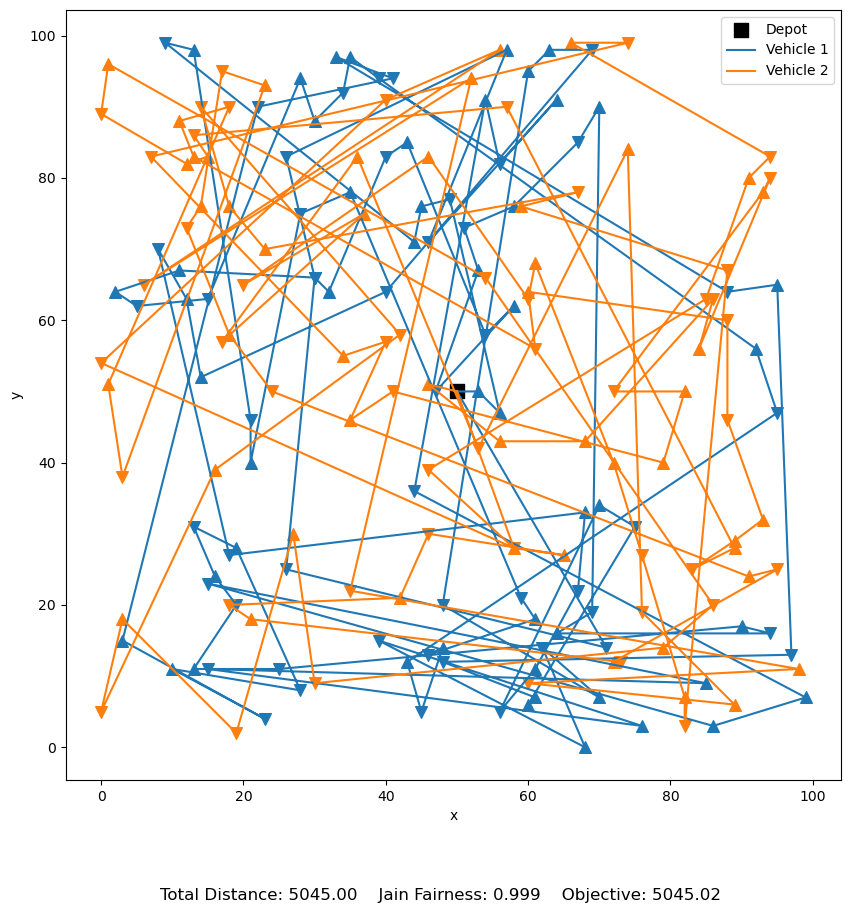

In [54]:
plot_routes(instance, routes)

## Subtask 2: Deriving a randomized construction heuristic
to be applied iteratively, yielding diverse promising results. For that we are going to take our Nearest Neighbor Heuristic, but modify it so that the vehicles decide randomly to pick up (if they can) or drop of (if they can). We should probably include a parameter that controls the bias towards one or the other. This is the "bias" parameter:
* if it is set to 0, the vehicle will always try to pick up more stuff if possible
* if it is set to 1, the vehicle will always try to drop off more stuff if possible

In [16]:
def randomized_nearest_neighbor_heuristic(instance, bias):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]
    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            random_number = random.random()
            if not open_requests and not current_vehicle_requests[k]:
                continue
            #print(f"lenopenreq: {len(open_requests)}")

            nearest_pick_up_location = None
            if open_requests:
                nearest_pick_up_location = min(
                    open_requests,
                    key=lambda req: a(req["pick_up"], current_vehicle_location[k])
                )
            if (nearest_pick_up_location is not None and
                (bias <= random_number or len(current_vehicle_requests[k]) == 0) and
                nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C):
                #print(f"PICKING UP: {nearest_pick_up_location}")
                #print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            elif current_vehicle_requests[k]:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                #print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    while any(current_vehicle_requests):
        for k in range(instance.n_k):
            if current_vehicle_requests[k]:

                nearest_drop_off_location = min(
                    current_vehicle_requests[k],
                    key=lambda req: a(req["drop_off"], current_vehicle_location[k])
                )

                current_vehicle_location[k] = nearest_drop_off_location["drop_off"]
                routes[k].append(nearest_drop_off_location["index"] + instance.n)
                current_vehicle_requests[k].remove(nearest_drop_off_location)
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"]
                n_served += 1
    return routes

In [17]:
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = randomized_nearest_neighbor_heuristic(instance, 0.5)

In [18]:
objective_function(instance, routes)

5418.092656680647

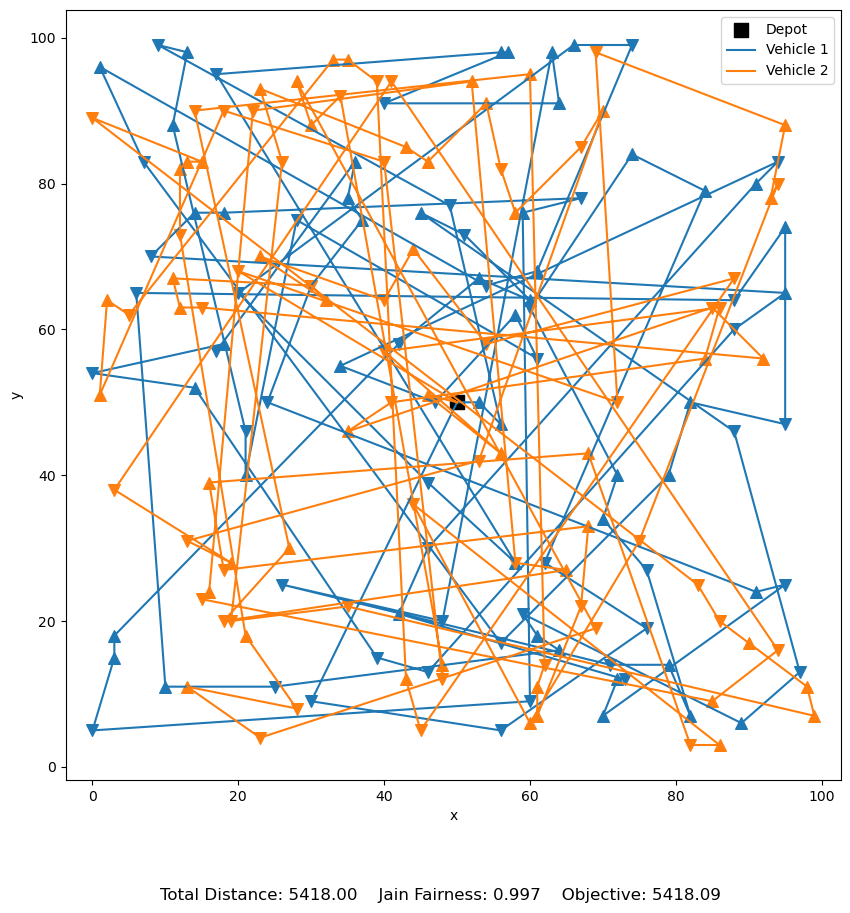

In [19]:
plot_routes(instance, routes)

### Another randomized Seconstruction heuristic
As we will find out later, this one is not so well suited for GRASP. This is why we generated another randomized constructio heuristic, based on our neearest neighbor constr. Heur.
This one samples from the k nearest candidates instead of always choosing the nearest one.

In [57]:
def another_randomized_nearest_neighbor_heuristic(instance, k=5):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]

    n_served = 0

    def k_nearest(elements, location, attr, k):
        """Return a random element chosen from the k nearest ones."""
        if not elements:
            return None
        sorted_elems = sorted(elements, key=lambda req: a(req[attr], location))
        k = min(k, len(sorted_elems))
        return random.choice(sorted_elems[:k])

    while n_served < instance.gamma:

        for k_i in range(instance.n_k):

            if not open_requests and not current_vehicle_requests[k_i]:
                continue

            # ---- PICKUP CANDIDATES ------------------------------------------------
            pickup_candidate = None
            if open_requests:
                pickup_candidate = k_nearest(open_requests, current_vehicle_location[k_i], "pick_up", k)

            # ---- PICKUP STEP ------------------------------------------------------
            if (pickup_candidate is not None and
                pickup_candidate["demand"] + current_vehicle_capacity[k_i] <= instance.C):

                current_vehicle_location[k_i] = pickup_candidate["pick_up"]
                routes[k_i].append(pickup_candidate["index"])
                current_vehicle_requests[k_i].append(pickup_candidate)
                current_vehicle_capacity[k_i] += pickup_candidate["demand"]
                open_requests.remove(pickup_candidate)

            # ---- DROP-OFF STEP ----------------------------------------------------
            elif current_vehicle_requests[k_i]:
                drop_candidate = k_nearest(current_vehicle_requests[k_i], current_vehicle_location[k_i], "drop_off", k)

                current_vehicle_location[k_i] = drop_candidate["drop_off"]
                routes[k_i].append(drop_candidate["index"] + instance.n)
                current_vehicle_requests[k_i].remove(drop_candidate)
                current_vehicle_capacity[k_i] -= drop_candidate["demand"]
                n_served += 1

    # ---- FINAL DROP-OFF LOOP ----------------------------------------------------
    while any(current_vehicle_requests):
        for k_i in range(instance.n_k):
            if current_vehicle_requests[k_i]:
                drop_candidate = k_nearest(current_vehicle_requests[k_i], current_vehicle_location[k_i], "drop_off", k)
                current_vehicle_location[k_i] = drop_candidate["drop_off"]
                routes[k_i].append(drop_candidate["index"] + instance.n)
                current_vehicle_requests[k_i].remove(drop_candidate)
                current_vehicle_capacity[k_i] -= drop_candidate["demand"]
                n_served += 1

    return routes

## Subtask 3: Pilot / Beam Search

In this subtask, we are asked to develop either a Beam Search or a Pilot Search algorithm to hopefully improve our performance.
At first glance, Pilot Search appears attractive because it provides a more accurate evaluation of each decision by performing a complete greedy rollout for every candidate move:

| Aspect | **Beam Search** | **Pilot Search** |
|--------|------------------|------------------|
| **Core Idea** | Keep the β most promising partial solutions at each level | Evaluate each extension by completing it with a greedy rollout |
| **Evaluation Method** | Objective function on partial solutions | Full greedy completion from each extension |
| **Nodes Explored** | O(β·n) | O(n²) |
| **Computational Cost** | Lower (only evaluates partial solutions) | Higher (requires full greedy completion per extension) |
| **Look-Ahead** | Limited to the current level | Dynamic via simulated completions |
| **Accuracy** | Depends on objective quality | Generally higher (accounts for downstream effects) |

However, we encountered a structural issue in our previous algorithm design:
our heuristics optimized the vehicle routes in a round-robin fashion, meaning all vehicles were advanced simultaneously.
As a result, if the optimal behavior was something like
> “Vehicle 1 picks up request 5 and then immediately request 7 because it’s nearby,”
this was not possible — the algorithm would switch to vehicle 2 right after assigning a single request to vehicle 1.

To enable independent optimization of each vehicle’s route, we propose defining the node set as:

$$
(\text{set of all vehicles}) \times ((\text{open and feasible pickups}) \cup (\text{current requests for drop-off}))
$$

However, the nearest-neighbor heuristic we used earlier is not suitable for such independent vehicle optimization.
It also ignores the fairness objective, making it unreliable as a rollout policy for a Pilot Search.

**Therefore, we decided to implement a Beam Search approach**,
which evaluates partial global solutions directly and naturally supports both multi-vehicle coordination and the fairness objective.
In order to build the search tree, we also define a "Node" class, that represents a node in this search tree.

In [20]:
# creating an own class to represent the nodes
@dataclass
class Node:
    routes: list           # list[list[int]]
    loc: list              # current location per vehicle
    capacity: list              # current used capacity
    onboard: list          # onboard[k] = list of requests
    open_reqs: list        # list of remaining requests
    n_served: int
    score: float           # evaluation score

    def copy(self):
        """Create a deep copy of the state, but without copying the underlying request dicts."""
        return Node(
            routes=[r.copy() for r in self.routes],
            loc=self.loc.copy(),
            capacity=self.capacity.copy(),
            onboard=[lst.copy() for lst in self.onboard],
            open_reqs=self.open_reqs.copy(),
            n_served=self.n_served,
            score=self.score
        )

In [21]:
# create the children nodes
def expand_node(instance, node):
    if node.open_reqs == [] and all(len(o)==0 for o in node.onboard):
        print("No possible moves in this state, served: ", node.n_served)
    successors = []
    for k in range(instance.n_k):
        # Pick up successors
        for req in node.open_reqs:
            if node.capacity[k] + req["demand"] <= instance.C:
                S2 = node.copy()
                old_loc = S2. loc[k] # move old vehicle
                new_loc = req["pick_up"]
                S2.loc[k] = new_loc
                S2.routes[k].append(req["index"])
                S2.onboard[k].append(req)
                S2.open_reqs.remove(req)
                S2.capacity[k] += req["demand"]
                S2.score  = objective_function(instance, S2.routes)
                successors.append(S2)
        # Drop off successors
        for req in node.onboard[k]:
            S2 = node.copy()
            old_loc = S2.loc[k]
            new_loc = req["drop_off"]
            S2.loc[k] = new_loc
            S2.routes[k].append(req["index"] + instance.n)
            S2.onboard[k].remove(req)
            S2.capacity[k] -= req["demand"]
            S2.score = objective_function(instance, S2.routes)
            S2.n_served += 1
            successors.append(S2)
    return successors

def flush_dropoffs(instance, node):
    for k in range(instance.n_k):
        while node.onboard[k]: # as long as we have still requests in the vehicle
            req = node.onboard[k][0] # take the first request on board of the vehicle
            node.loc[k] = req["drop_off"] # set the vehicle location to the drop of point
            node.routes[k].append(req["index"] + instance.n) # appending drop off location to route
            node.capacity[k] -= req["demand"] # decreasing capacity
            node.onboard[k].remove(req)
            node.n_served += 1
    return node

In [22]:
def beam_search(instance, beta):
    init = Node(
        routes = [[] for _ in range(instance.n_k)],
        loc = [instance.depot for _ in range(instance.n_k)],
        capacity = [0 for _ in range(instance.n_k)],
        onboard=[[] for _ in range(instance.n_k)],
        open_reqs=instance.requests.copy(),
        n_served=0,
        score=0.0
    )
    beam = [init]
    while True:
        if all(s.n_served >= instance.gamma for s in beam):
            out = min(successors, key=lambda s: s.score)
            for k in range(instance.n_k): # delivering the remaining drop offs
                while out.onboard[k]: # as long as we have still requests in the vehicle
                    req = out.onboard[k][0] # take the first request on board of the vehicle
                    out.loc[k] = req["drop_off"] # set the vehicle location to the drop of point
                    out.routes[k].append(req["index"] + instance.n) # appending drop off location to route
                    out.capacity[k] -= req["demand"] # decreasing capacity
                    out.onboard[k].remove(req)
                    out.n_served += 1
            return out.routes
        successors = []
        for s in beam:
            successors.extend(expand_node(instance, s))

        successors.sort(key=lambda s: s.score)
        beam = successors[:beta]

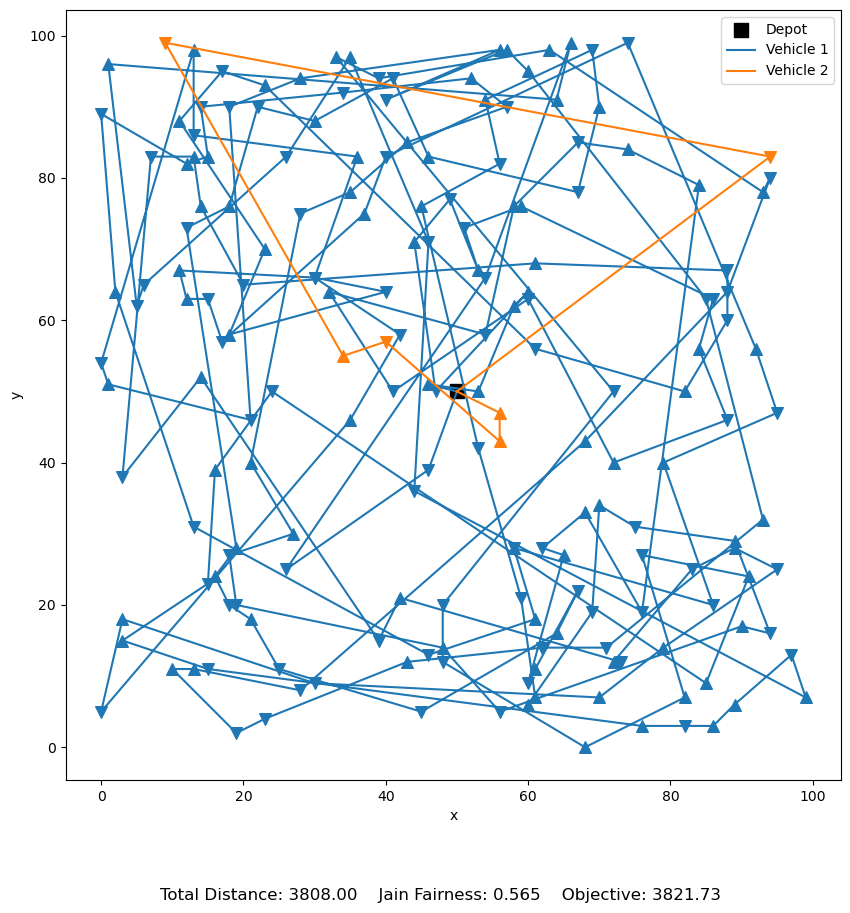

In [58]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = beam_search(instance, 50)
plot_routes(instance, routes)

## Subtask 4: Developing a framework for basic local search

which is able to deal with **different neighborhood structures** and different **step functions**

Because we experimented quite a bit, we  implemented more than three neighborhood structures:

1. **RelocateCompact**: Takes a request from Vehicle A and moves it to Vehicle B, where Vehicle B drops off the request immediately after pickup.

2. **RelocateFlexible**: Takes a request from Vehicle A and moves it to Vehicle B, attempting to drop it off not immediately but at a later, feasible time. So it basically does the same  as relocateCompact, but gives us more neighbors (and is more expansive to evaluate)

3. **RelocateRandomly**: A special randomized version of flexible relocation, designed specifically for Simulated Annealing. Instead of generating all possible neighbors, it randomly selects one vehicle with pickups, one request from that vehicle, and one target vehicle, then randomly chooses a feasible insertion. Not really suited for LS/VND/GRASP in general, but made specifically for SA.

4. **SwapRequests**: Swaps a request from Vehicle A with a request from Vehicle B, attempting all feasible compact insertion positions for both requests in their new vehicles. Very expensive, only first_improvement is recomended with this neighborhood since best_improvement takes for ever for a single iteration. And since best_improvement generally produces better results, this neighborhood structure is not used that much.

5. **DelayDropoffs**: For each drop-off in each vehicle's route, tries to move the drop-off as far back (later) in the route as possible while maintaining capacity feasibility and ensuring the pickup remains before the drop-off. The goal of this neighborhood structure is ptimicing the capacity of each vehicle.

6. **AdvancePickups**: For each pickup in each vehicle's route, tries to move the pickup as early (forward) in the route as possible while maintaining capacity feasibility and ensuring the pickup remains before the drop-off. Again, the goal of this neighborhood structure is ptimicing the capacity of each vehicle.

7. **ReplaceWithUnserved**: Replaces a currently served request with an unserved request, exploring all feasible compact insertion positions for the new request. Only useful when gamma < n.

Down below, you can also find delta-evaluated versions of some of the neighborhood structures.
Furthermore, we have created a new State class that only consists of the data we need for efficient local search operations.

In [25]:
@dataclass(frozen=True)
class State:
    routes: tuple[tuple[int]]
    served: frozenset
    unserved: frozenset
    score: float

    @staticmethod
    def from_routes(instance, routes):
        """Build State from raw routes (list of lists)."""
        served = set()
        for vroute in routes:
            for idx in vroute:
                if idx < instance.n:
                    served.add(idx)
        served = frozenset(served)
        unserved = frozenset(set(range(instance.n)) - served)
        score = objective_function(instance, routes)
        return State(
            routes=tuple(tuple(r) for r in routes),
            served=served,
            unserved=unserved,
            score=score
        )

In [26]:
# Some utility functions
def remove_request_from_route(route, req_idx, n):
    """Remove both pickup(req_idx) and dropoff(req_idx+n)."""
    new_route = [x for x in route if x != req_idx and x != req_idx+n]
    return new_route


def insert_request_compact(route, req_idx, n):
    """Insert pickup and then dropoff immediately after."""
    new_route = route.copy()
    # insert pickup at all possible positions
    for pos in range(len(route)+1):
        tmp = new_route[:pos] + [req_idx, req_idx + n] + new_route[pos:]
        yield tmp

# limited window version of insert_request_compact
def insert_request_compact_window(route, req_idx, n, window=2):
    L = len(route)
    # find original position if exists
    original_pos = None
    for i, x in enumerate(route):
        if x == req_idx:
            original_pos = i
            break
        # define positions to try
        if original_pos is not None:
            start = max(0, original_pos - window)
            end = min(L+1, original_pos + window + 1)
            positions = range(start, end)
        else:
            positions = range(L+1)
        for pos in positions:
            tmp = route[:pos] + [req_idx, req_idx+n] + route[pos:]
            yield tmp

def insert_request_flexible(route, req_idx, n):
    """Try all pickup and dropoff insertion positions (pickup_pos < dropoff_pos)."""
    L = len(route)
    for p in range(L+1):            # pickup position
        for d in range(p+1, L+2):   # dropoff position after pickup
            new_r = route[:p] + [req_idx] + route[p:d] + [req_idx+n] + route[d:]
            yield new_r


def capacity_feasible(instance, route):
    """Check capacity along route."""
    load = 0
    for idx in route:
        #idx = idx - 1
        if idx <= instance.n:    # pickup
            load += instance.requests[idx - 1]["demand"] # fucking off-by-one
            #print(f"Picking up load for idx {idx}, capacity is now at {load}")
            if load > instance.C:
                #print("Load too high!!")
                return False
        else:                   # dropoff
            #print(f"(real) index {real} (idx: {idx}) has demand {instance.requests[real]["demand"]} while current load is {load}")
            load -= instance.requests[idx - instance.n - 1]["demand"]
            if load < 0:
                #print("Load below zero!!")
                return False
    return True

In [27]:
class RelocateCompact:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue     # dropoff, skip
                req_idx = idx
                # Try removing from one vehicle, inserting in another
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_compact(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)


# takin request from one vehicle to another vehicle
class RelocateFlexible:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes] # converting to list
        for v_from, route_from in enumerate(routes): # vehicle and route
            for idx in route_from:
                if idx >= self.n: # it's a drop-off index
                    continue
                req_idx = idx # it's a pick up index
                for v_to in range(len(routes)): # iterating over all other possible vehicles
                    if v_to == v_from: # we obviously don't want to move to our own vehicle again
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_flexible(routes[v_to], req_idx, self.n): # iterating over all
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from): # feasible drop-off locations
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)

# special version, later used for Simulated Annealing
class RelocateRandomly:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state:State):
        routes = [list(r) for r in state.routes] # converting to list
        vehicles_with_pickups = [i for i, r in enumerate(routes) if any(idx < self.n for idx in r)] # pick a random vehicle with at least one pickup
        if not vehicles_with_pickups:
            print("No vehicle with pickups!")
            return  # no feasible move

        v_from = random.choice(vehicles_with_pickups)
        route_from = routes[v_from]

        # pick a random pickup in that vehicle
        pickup_indices = [idx for idx in route_from if idx < self.n]
        req_idx = random.choice(pickup_indices)

        # pick a random other vehicle to move to
        v_to_candidates = [i for i in range(len(routes)) if i != v_from]
        v_to = random.choice(v_to_candidates)
        route_to = routes[v_to]

        # remove request from original route
        r_from = remove_request_from_route(route_from, req_idx, self.n)

        # try inserting randomly into the target vehicle
        # try inserting randomly into the target vehicle, only keep feasible insertions
        feasible_insertions = [
            r for r in insert_request_flexible(route_to, req_idx, self.n)
            if capacity_feasible(self.instance, r)
        ]
        if not feasible_insertions:
            print("No feasable insertion!")
            return  # no feasible insertion
        r_to = random.choice(feasible_insertions)

        # assemble new routes
        new_routes = []
        for k, r in enumerate(routes):
            if k == v_from:
                new_routes.append(r_from)
            elif k == v_to:
                new_routes.append(r_to)
            else:
                new_routes.append(r)

        # yield a single random neighbor
        yield State.from_routes(self.instance, new_routes)

# the problem with this class is that it is impossible to use with best improvement because it literally creates millions of neighbors.
class SwapRequests:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        # all pairs of vehicles
        for v1 in range(len(routes)):
            for v2 in range(v1+1, len(routes)):
                for idx1 in routes[v1]:
                    if idx1 >= self.n:
                        continue
                    for idx2 in routes[v2]:
                        if idx2 >= self.n:
                            continue

                        # remove both requests
                        r1_rem = remove_request_from_route(routes[v1], idx1, self.n)
                        r2_rem = remove_request_from_route(routes[v2], idx2, self.n)

                        # try inserting each into the other vehicle (compact insertion)
                        for r1_add in insert_request_compact(r1_rem, idx2, self.n):
                            for r2_add in insert_request_compact(r2_rem, idx1, self.n):
                                if capacity_feasible(self.instance, r1_add) and capacity_feasible(self.instance, r2_add):
                                    new_routes = []
                                    for k, r in enumerate(routes):
                                        if k == v1:
                                            new_routes.append(r1_add)
                                        elif k == v2:
                                            new_routes.append(r2_add)
                                        else:
                                            new_routes.append(r)
                                    yield State.from_routes(self.instance, new_routes)



class DelayDropoffs:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n  # number of requests

    @staticmethod
    def _remove_at(route, pos):
        """Return a new list with element at pos removed."""
        return route[:pos] + route[pos+1:]

    @staticmethod
    def _insert_at(route, pos, node):
        """Return a new list with node inserted at pos."""
        return route[:pos] + [node] + route[pos:]

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]  # copy outer list, keep inner lists as copies
        num_vehicles = len(routes)

        for v in range(num_vehicles):
            route = routes[v]
            L = len(route)
            # iterate over positions and find drop-offs
            for pos in range(L):
                node = route[pos]
                if node <= self.n:
                    # pickup node, skip
                    continue

                # node is a drop-off (value in n+1 .. 2n)
                drop_req = node - self.n  # request id (1-based)
                # find pickup position in this route (must exist if route is legal)
                try:
                    pickup_pos = route.index(drop_req)
                except ValueError:
                    # pickup not in same route: skip (we only reorder within same vehicle)
                    continue

                # candidate positions are from pos+1 up to len(route) (inclusive at end)
                # we want the farthest position j such that inserting the drop at j keeps feasibility
                # (we remove original drop at pos first, then try to insert at later positions)
                route_without_drop = self._remove_at(route, pos)
                best_pos = None

                # Try insertion positions from the end backwards to find maximal feasible push quickly
                for j in range(len(route_without_drop), pos, -1):
                    candidate = self._insert_at(route_without_drop, j, node)
                    # Ensure pickup still before drop (pickup_pos may shift if pickup was after removed pos)
                    # Compute new pickup position:
                    # if pickup_pos < pos: pickup_pos unchanged
                    # if pickup_pos > pos: pickup_pos' = pickup_pos - 1
                    if pickup_pos > pos:
                        new_pickup_pos = pickup_pos - 1
                    else:
                        new_pickup_pos = pickup_pos
                    # new drop pos is j (since inserted at j in route_without_drop)
                    new_drop_pos = j
                    if new_pickup_pos >= new_drop_pos:
                        # pickup would be after or at same position as drop -> invalid
                        continue

                    # capacity feasibility check for this candidate route (whole-route check, but it's cheap)
                    if capacity_feasible(self.instance, candidate):
                        best_pos = j
                        # since we're iterating from far to near, the first feasible j is the maximal push
                        break

                if best_pos is not None and best_pos != pos:
                    # build new_routes with this pushed drop-off for vehicle v
                    new_routes = []
                    for k, r in enumerate(routes):
                        if k == v:
                            new_routes.append(self._insert_at(self._remove_at(r, pos), best_pos, node))
                        else:
                            new_routes.append(r)
                    yield State.from_routes(self.instance, new_routes)


class AdvancePickups:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    @staticmethod
    def _remove_at(route, pos):
        return route[:pos] + route[pos+1:]

    @staticmethod
    def _insert_at(route, pos, node):
        return route[:pos] + [node] + route[pos:]

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        num_vehicles = len(routes)

        for v in range(num_vehicles):
            route = routes[v]
            L = len(route)

            for pos in range(L):
                node = route[pos]
                if node > self.n:
                    # skip drop-offs
                    continue

                pickup = node
                drop = pickup + self.n

                # locate drop position
                try:
                    drop_pos = route.index(drop)
                except ValueError:
                    # drop is not in same route, skip
                    continue

                # Remove pickup
                route_wo_pickup = self._remove_at(route, pos)

                # drop position shifts left by 1 only if pickup was before drop
                if pos < drop_pos:
                    new_drop_pos = drop_pos - 1
                else:
                    new_drop_pos = drop_pos

                best_pos = None

                # Try earliest positions: from 0 up to new_drop_pos-1
                # We iterate forward so the *first* feasible is the earliest possible
                for j in range(0, new_drop_pos):
                    candidate = self._insert_at(route_wo_pickup, j, pickup)

                    # new pickup position = j
                    # drop node is still at new_drop_pos
                    # but if j <= new_drop_pos: drop shifts right by +1
                    if j <= new_drop_pos:
                        candidate_drop_pos = new_drop_pos + 1
                    else:
                        candidate_drop_pos = new_drop_pos

                    # enforce pickup < drop
                    if j >= candidate_drop_pos:
                        continue

                    # capacity check
                    if capacity_feasible(self.instance, candidate):
                        best_pos = j
                        break

                # if we found an earlier feasible position
                if best_pos is not None and best_pos != pos:
                    new_routes = []
                    for k, r in enumerate(routes):
                        if k == v:
                            new_routes.append(self._insert_at(self._remove_at(r, pos), best_pos, pickup))
                        else:
                            new_routes.append(r)

                    yield State.from_routes(self.instance, new_routes)


class ReplaceWithUnserved:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]

        # find all currently served requests
        served = set()
        for r in routes:
            for x in r:
                if x < self.n:
                    served.add(x)

        # unserved candidates
        unserved = [i for i in range(self.n) if i not in served]

        if not unserved:
            return  # no moves possible

        for v, route in enumerate(routes):
            # iterate over served requests in this vehicle
            for req_out in route:
                if req_out >= self.n:
                    continue  # dropoff, skip

                # remove this request from the route
                route_removed = remove_request_from_route(route, req_out, self.n)

                # try replacing it with an unserved one
                for req_in in unserved:
                    # insert at all possible compact positions
                    for route_added in insert_request_compact(route_removed, req_in, self.n):

                        # check feasibility
                        if not capacity_feasible(self.instance, route_added):
                            continue

                        # build full solution
                        new_routes = []
                        for k, r in enumerate(routes):
                            if k == v:
                                new_routes.append(route_added)
                            else:
                                new_routes.append(r)

                        yield State.from_routes(self.instance, new_routes)

Here are the delta evaluated versions. However, they are generally not faster than the normal ones

In [28]:
# Here's the same code but with delta evaluation:
class RelocateCompact_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue     # dropoff, skip
                req_idx = idx
                # Try removing from one vehicle, inserting in another
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_compact(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)

                            delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
                            new_score = state.score + delta
                            yield State(
                                routes=tuple(tuple(r) for r in new_routes),
                                served=state.served,      # you can recompute if needed
                                unserved=state.unserved,
                                score=new_score
                            )

class RelocateFlexible_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes] # converting to list
        for v_from, route_from in enumerate(routes): # vehicle and route
            for idx in route_from:
                if idx >= self.n: # it's a drop-off index
                    continue
                req_idx = idx # it's a pick up index
                for v_to in range(len(routes)): # iterating over all other possible vehicles
                    if v_to == v_from: # we obviously don't want to move to our own vehicle again
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_flexible(routes[v_to], req_idx, self.n): # iterating over all
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from): # feasible drop-off locations
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            delta =  delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
                            new_score = state.score + delta
                            yield State(
                                routes=tuple(tuple(r) for r in new_routes),
                                served=state.served,      # you can recompute if needed
                                unserved=state.unserved,
                                score=new_score
                            )

# special version, later used for Simulated Annealing
class RelocateRandomly_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state:State):
        routes = [list(r) for r in state.routes] # converting to list
        vehicles_with_pickups = [i for i, r in enumerate(routes) if any(idx < self.n for idx in r)] # pick a random vehicle with at least one pickup
        if not vehicles_with_pickups:
            return  # no feasible move

        v_from = random.choice(vehicles_with_pickups)
        route_from = routes[v_from]

        # pick a random pickup in that vehicle
        pickup_indices = [idx for idx in route_from if idx < self.n]
        req_idx = random.choice(pickup_indices)

        # pick a random other vehicle to move to
        v_to_candidates = [i for i in range(len(routes)) if i != v_from]
        v_to = random.choice(v_to_candidates)
        route_to = routes[v_to]

        # remove request from original route
        r_from = remove_request_from_route(route_from, req_idx, self.n)

        # try inserting randomly into the target vehicle
        # try inserting randomly into the target vehicle, only keep feasible insertions
        feasible_insertions = [
            r for r in insert_request_flexible(route_to, req_idx, self.n)
            if capacity_feasible(self.instance, r)
        ]
        if not feasible_insertions:
            return  # no feasible insertion
        r_to = random.choice(feasible_insertions)

        # assemble new routes
        new_routes = []
        for k, r in enumerate(routes):
            if k == v_from:
                new_routes.append(r_from)
            elif k == v_to:
                new_routes.append(r_to)
            else:
                new_routes.append(r)

        # yield a single random neighbor
        delta =  delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
        new_score = state.score + delta
        yield State(
            routes=tuple(tuple(r) for r in new_routes),
            served=state.served,      # you can recompute if needed
            unserved=state.unserved,
            score=new_score
        )

class SwapRequests_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]

        # all pairs of vehicles
        for v1 in range(len(routes)):
            for v2 in range(v1+1, len(routes)):
                for idx1 in routes[v1]:
                    if idx1 >= self.n:
                        continue
                    for idx2 in routes[v2]:
                        if idx2 >= self.n:
                            continue

                        # remove both requests
                        r1_rem = remove_request_from_route(routes[v1], idx1, self.n)
                        r2_rem = remove_request_from_route(routes[v2], idx2, self.n)

                        # try inserting each into the other vehicle (compact insertion)
                        for r1_add in insert_request_compact(r1_rem, idx2, self.n):
                            for r2_add in insert_request_compact(r2_rem, idx1, self.n):
                                if capacity_feasible(self.instance, r1_add) and capacity_feasible(self.instance, r2_add):
                                    new_routes = []
                                    for k, r in enumerate(routes):
                                        if k == v1:
                                            new_routes.append(r1_add)
                                        elif k == v2:
                                            new_routes.append(r2_add)
                                        else:
                                            new_routes.append(r)
                                        delta = delta_objective(
                                            self.instance,
                                            state.routes,                    # old state routes (tuple of tuples)
                                            tuple(tuple(r) for r in new_routes)  # new routes in same format
                                        )
                                        new_score = state.score + delta
                                        yield State(
                                            routes=tuple(tuple(r) for r in new_routes),
                                            served=state.served,      # you can recompute if needed
                                            unserved=state.unserved,
                                            score=new_score
                                        )

We define the **first improevement** and **best imporvement** step functions

In [108]:
def first_improvement(state, neighborhood):
    i = 0
    for neigh in neighborhood.neighbors(state):
        i += 1
        if neigh.score < state.score:
            #print(f"found fist improvement after looking at {i} neighbors")
            return neigh
    #print(f"Did not find an improvement after lookign at {i} neighbors")
    return state

def best_improvement(state, neighborhood):
    best = state
    i = 0
    for neigh in neighborhood.neighbors(state):
        i += 1
        if neigh.score < best.score:
            best = neigh
    #print("Found new best neighbor in neighborhood of size: ", i)
    return best

## Subtask 5: Develop at least three different meaningful neighborhood structures (and LOCAL SEARCH!)
We have already done this in the previous part. But now let's test these neighborhood srtructures by implementing a simple local search algorithm.

In [30]:
def local_search(instance, routes, neighborhood, step_function, max_iter):
    state = State.from_routes(instance, routes)
    i = 0
    for it in range(max_iter):
        i += 1
        improved = False
        new_state = step_function(state, neighborhood)
        if new_state.score < state.score:
            state = new_state
            improved = True
            if improved:
                print("Improved Score to: ", state.score)
        if not improved:
            break
    print(f"ran {i} iterations")
    return state.routes

In [31]:
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = nearest_neighbor_heuristic(instance)
print("score for initial routes: ", objective_function(instance, routes))
routes_improved = local_search(instance, routes, ReplaceWithUnserved(instance), best_improvement, 100)
print("score of improved routes: ", objective_function(instance, routes_improved))

score for initial routes:  5045.017549591446
Found new best neighbor in neighborhood of size:  14313
Improved Score to:  4943.000373291826
Found new best neighbor in neighborhood of size:  14220
Improved Score to:  4858.0139069182915
Found new best neighbor in neighborhood of size:  19164
Improved Score to:  4783.043160694902
Found new best neighbor in neighborhood of size:  18529
Improved Score to:  4728.020999678661
Found new best neighbor in neighborhood of size:  19345
Improved Score to:  4683.008530072686
Found new best neighbor in neighborhood of size:  18327
Improved Score to:  4618.029812293475
Found new best neighbor in neighborhood of size:  19739
Improved Score to:  4611.027029759
Found new best neighbor in neighborhood of size:  21343
Improved Score to:  4575.044029191789
Found new best neighbor in neighborhood of size:  21428
Improved Score to:  4563.050680427178
Found new best neighbor in neighborhood of size:  21334
Improved Score to:  4554.046006149878
Found new best ne

### Quick Experiment:
Since it says in our assignment:
>
> Use the solution of the deterministic construction heuristic to test the other implementations:
> i. Local search for at least three selected (possibly composite) neighborhood structures using
> each of the two step functions (i.e., at least six different algorithm variants)
>
we are going to do that now

In [32]:
def run_local_search_wrapper(instance, routes, neighborhoods, step_functions, max_iter=50):
    """
    Run local search on initial routes with multiple neighborhoods and step functions.
    Returns a dictionary with results for plotting.
    """
    results = {}

    for neigh in neighborhoods:
        neigh_name = neigh.__class__.__name__
        for step_func in step_functions:
            func_name = step_func.__name__
            # Reset initial routes each time
            print(f"Running {neigh_name} with {func_name}")
            start = time.time()
            improved_routes = local_search(instance, routes, neigh, step_func, max_iter)
            end = time.time()
            runtime = end - start
            score = objective_function(instance, improved_routes)
            results[f"{neigh_name} - {func_name}"] = {
                "routes": improved_routes,
                "score": score,
                "runtime": runtime
            }
            print(f"Score for {neigh_name} - {func_name}: {score}, runtime: {runtime:.3f} sec")
    return results

In [33]:
neighborhoods = [RelocateCompact(instance), RelocateFlexible(instance), DelayDropoffs(instance), AdvancePickups(instance)]
step_functions = [first_improvement, best_improvement]

filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = nearest_neighbor_heuristic(instance)
print("Score for initial routes: ", objective_function(instance, routes))

results = run_local_search_wrapper(instance, routes, neighborhoods, step_functions, max_iter=100)

Score for initial routes:  5045.017549591446
Running RelocateCompact with first_improvement
Improved Score to:  5042.040171973435
Improved Score to:  5039.0443364939065
Improved Score to:  5033.079547794618
Improved Score to:  5021.117547317908
Improved Score to:  5018.139203070709
Improved Score to:  4963.234061575448
Improved Score to:  4962.266606112759
Improved Score to:  4950.625712792116
Improved Score to:  4941.690539006191
Improved Score to:  4938.891685930088
Improved Score to:  4927.561846437905
Improved Score to:  4926.666930422349
Improved Score to:  4904.163942684429
Improved Score to:  4903.216547285169
Improved Score to:  4889.834043904275
Improved Score to:  4876.697352199586
Improved Score to:  4865.566977248355
Improved Score to:  4856.737736967763
Improved Score to:  4847.703568415048
Improved Score to:  4845.806350388276
Improved Score to:  4834.760537889116
Improved Score to:  4815.576460560048
Improved Score to:  4791.828832052497
Improved Score to:  4782.49997792

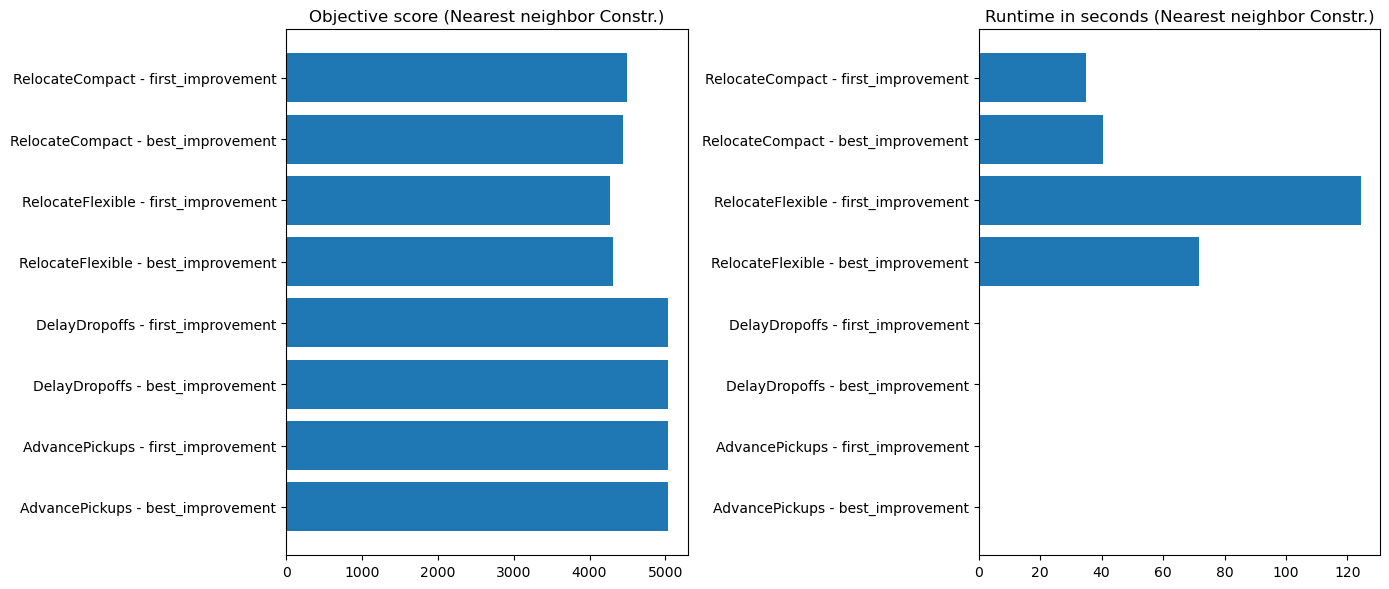

In [34]:
labels = list(results.keys())
scores = [results[k]["score"] for k in labels]
times = [results[k]["runtime"] for k in labels]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Score plot
ax[0].barh(labels, scores)
ax[0].set_title("Objective score (Nearest neighbor Constr.)")
ax[0].invert_yaxis()

# Runtime plot
ax[1].barh(labels, times)
ax[1].set_title("Runtime in seconds (Nearest neighbor Constr.)")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [35]:
neighborhoods = [RelocateCompact(instance), RelocateFlexible(instance), DelayDropoffs(instance), AdvancePickups(instance)]
step_functions = [first_improvement, best_improvement]

filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = beam_search(instance, 50)
print("Score for initial routes: ", objective_function(instance, routes))

results = run_local_search_wrapper(instance, routes, neighborhoods, step_functions, max_iter=100)

Score for initial routes:  3821.7317828479413
Running RelocateCompact with first_improvement
Improved Score to:  3804.656666329049
Improved Score to:  3803.4112713089858
Improved Score to:  3801.27690463794
Improved Score to:  3800.238032652278
Improved Score to:  3791.865649005233
Improved Score to:  3783.6829288838794
Improved Score to:  3783.485822736004
ran 8 iterations
Score for RelocateCompact - first_improvement: 3783.485822736004, runtime: 0.455 sec
Running RelocateCompact with best_improvement
Improved Score to:  3803.646709571326
Improved Score to:  3796.3876258168775
Improved Score to:  3784.2361155058866
Improved Score to:  3777.067091655296
Improved Score to:  3762.220181714668
Improved Score to:  3756.1188807749922
Improved Score to:  3750.21140671454
Improved Score to:  3746.788430143489
ran 9 iterations
Score for RelocateCompact - best_improvement: 3746.788430143489, runtime: 1.221 sec
Running RelocateFlexible with first_improvement
Improved Score to:  3821.507779094563

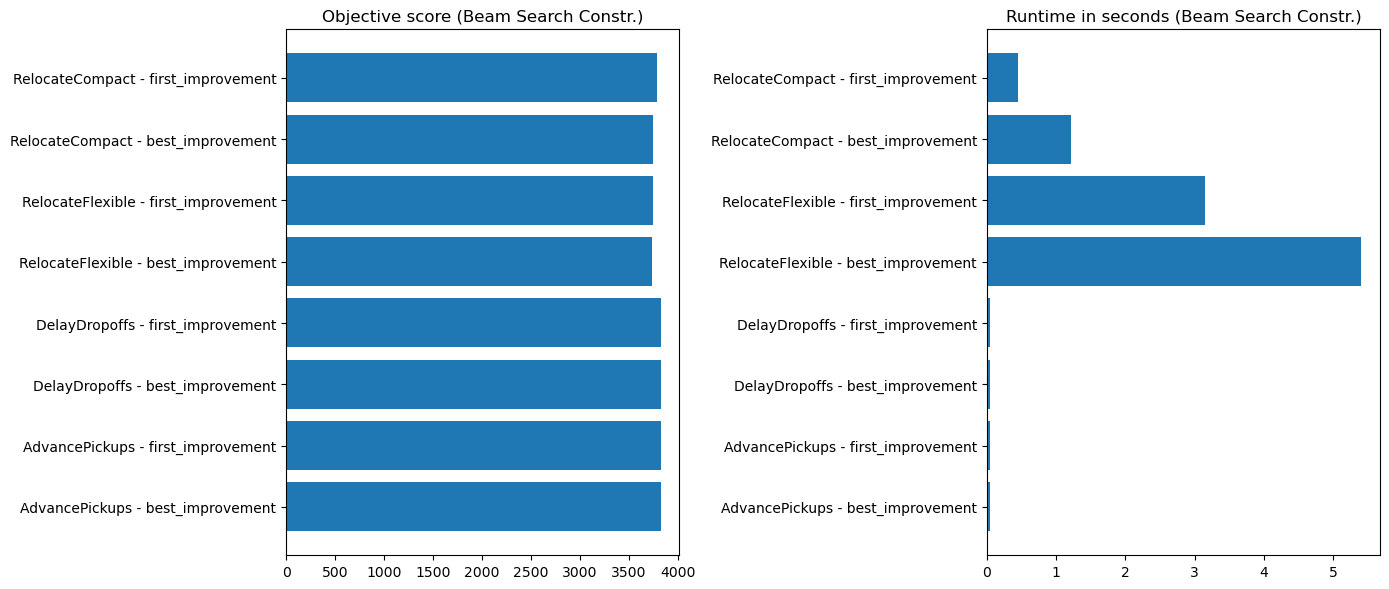

In [36]:
labels = list(results.keys())
scores = [results[k]["score"] for k in labels]
times = [results[k]["runtime"] for k in labels]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Score plot
ax[0].barh(labels, scores)
ax[0].set_title("Objective score (Beam Search Constr.)")
ax[0].invert_yaxis()

# Runtime plot
ax[1].barh(labels, times)
ax[1].set_title("Runtime in seconds (Beam Search Constr.)")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Subtask 6: Variable Neighborhood descent
Develop or make use of a Variable Neighborhood Descent (VND) framework which uses your
neighborhood structures. This method is a local search metaheuristic that uses a list of neighborhood structures instead of a single one.
Method takes advantage of the following observations:

1. A local optimum with respect to one neighborhood structure
is not necessarily a local optimum with respect to another.

2. A global optimum is a local optimum with respect to all possible neighborhood
structures.

3. For many problems good local optima are relatively close together.


The order of neighborhood structures changes the solution! ("smaller" Neighborhood structures should be first)

In [111]:
def variable_neighborhood_descent(initial_state, neighborhoods, step_fn, max_iter=100):
    state = initial_state
    i  = 0
    for it in range(max_iter):
        i += 1
        improved = False
        for N in neighborhoods:
            new_state = step_fn(state, N)
            if new_state.score < state.score:
                #print("Improved Score to: ", state.score, "with neighborhood ", N.__class__.__name__)
                state = new_state
                improved = True
        if not improved:
            print(f"No more Improvements found after {it} iterations!")
            break
    print(f"ran {i} iterations")
    return state.routes

In [107]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
#routes = nearest_neighbor_heuristic(instance)
routes = beam_search(instance, 50)
initial = State.from_routes(instance, routes)

# defining a list of neighborhoods
neighborhoods = [
    DelayDropoffs(instance),
    AdvancePickups(instance),
    RelocateCompact(instance),
    RelocateFlexible(instance),
    ReplaceWithUnserved(instance),
]

routes = variable_neighborhood_descent(
    initial,
    neighborhoods,
    step_fn=best_improvement,
    max_iter=50
)

plot_routes(instance, routes)

  0%|          | 0/50 [00:00<?, ?it/s]

Found new best neighbor in neighborhood of size:  35
Found new best neighbor in neighborhood of size:  35
Found new best neighbor in neighborhood of size:  641
Found new best neighbor in neighborhood of size:  1273


  2%|▏         | 1/50 [00:03<03:14,  3.97s/it]

Found new best neighbor in neighborhood of size:  30209
Found new best neighbor in neighborhood of size:  38
Found new best neighbor in neighborhood of size:  38
Found new best neighbor in neighborhood of size:  1310
Found new best neighbor in neighborhood of size:  3111


  2%|▏         | 1/50 [00:07<05:55,  7.25s/it]


KeyboardInterrupt: 

## Subtask 7: GRASP (Greedy randomized Adaptive Search Procedure)
Now we are asked to implement GRASP using our randomized nearest neighbor construction heuristic from earlier, togehter with a step funciton
The algorithm works in two stages:

1.) greedy randomized construction

2.) Local search typically with best improvement

In [40]:
def GRASP(instance):
    solutions = []
    for i in range(10):
        random_bias = 1 - (0.1 * i)
        print(f"testing with bias {random_bias}")
        greedy_randomized = randomized_nearest_neighbor_heuristic(instance, random_bias)
        initial = State.from_routes(instance, greedy_randomized)
        neighborhoods = [
            DelayDropoffs(instance),
            AdvancePickups(instance),
            RelocateCompact(instance),
            RelocateFlexible(instance),
            ReplaceWithUnserved(instance),
        ]
        improvement = variable_neighborhood_descent(initial, neighborhoods, first_improvement, 50) # set to first improvement for speed, best improevemt for quality
        solutions.append(improvement)
        #print(f"Imrovement score: {improvement.score}")

    best_solution = min(solutions, key=lambda s: s.score)
    return best_solution.routes

testing with bias 1.0
Improved Score to:  6231.122526867731 with neighborhood  RelocateCompact
Improved Score to:  6224.147159141094 with neighborhood  DelayDropoffs
Improved Score to:  6217.1523524584245 with neighborhood  RelocateFlexible
Improved Score to:  6216.164539387036 with neighborhood  RelocateCompact
Improved Score to:  6205.243369477373 with neighborhood  DelayDropoffs
Improved Score to:  6194.254069546242 with neighborhood  RelocateFlexible
Improved Score to:  6193.342831518177 with neighborhood  RelocateCompact
Improved Score to:  6149.574124008427 with neighborhood  DelayDropoffs
Improved Score to:  6139.589547903084 with neighborhood  RelocateFlexible
Improved Score to:  6138.693441917701 with neighborhood  RelocateCompact
Improved Score to:  6136.769466955795 with neighborhood  DelayDropoffs
Improved Score to:  6133.774855896012 with neighborhood  RelocateFlexible
Improved Score to:  6132.843253848973 with neighborhood  RelocateCompact
Improved Score to:  6125.1408944

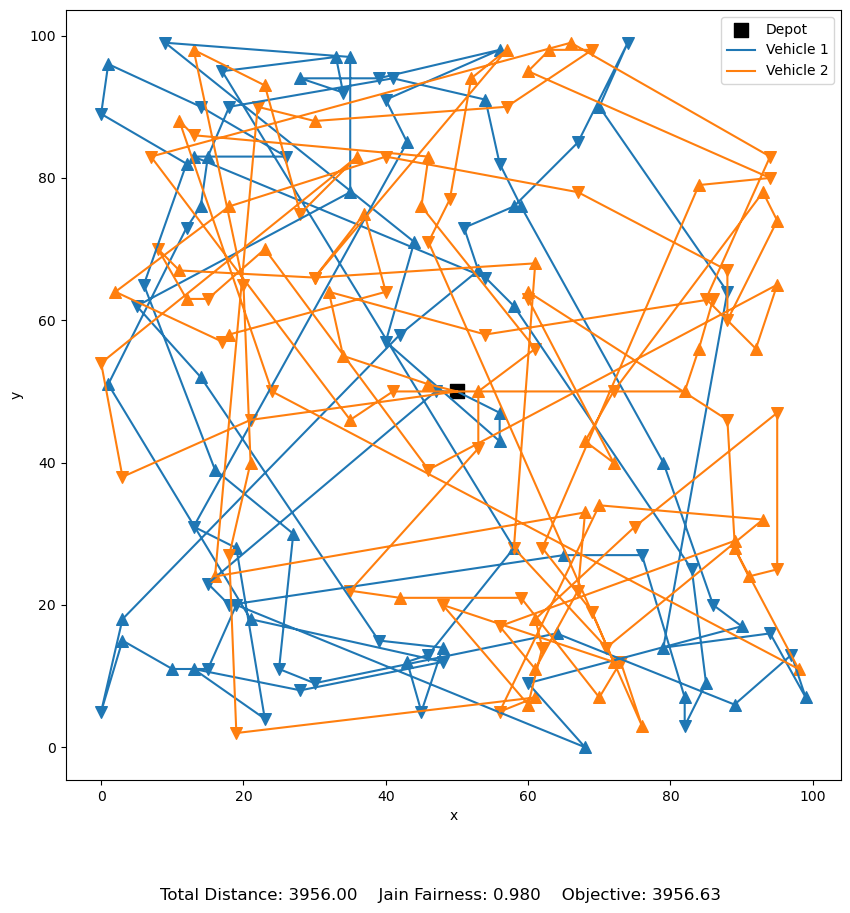

In [41]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = GRASP(instance)
plot_routes(instance, routes)

### Another GRASP
You can see above that the GRASP somehow does it's thing, but not really. This is we we also run grasp with another randomized construction heruistic

In [113]:
def anotherGRASP(instance):
    solutions = []
    for i in range(25):
        # bias controls greediness vs randomness: 1 = fully greedy, 0 = fully random
        k = 25 - i
        print(f"Testing with k {k:.2f}")
        greedy_randomized = another_randomized_nearest_neighbor_heuristic(instance, k)
        initial = State.from_routes(instance, greedy_randomized)
        neighborhoods = [DelayDropoffs(instance), AdvancePickups(instance)]
        improvement = variable_neighborhood_descent(initial, neighborhoods, best_improvement, max_iter=50)
        score = objective_function(instance, improvement)
        solutions.append({"routes": improvement, "score": score})
        print(f"Score: {score}")

    # select best solution from all iterations
    best_solution = min(solutions, key=lambda s: s["score"])
    return best_solution["routes"]


Testing with k 25.00
No more Improvements found after 13 iterations!
ran 14 iterations
Score: 8038.05056573745
Testing with k 24.00
No more Improvements found after 9 iterations!
ran 10 iterations
Score: 8102.017346862834
Testing with k 23.00
No more Improvements found after 7 iterations!
ran 8 iterations
Score: 8078.056468175942
Testing with k 22.00
No more Improvements found after 7 iterations!
ran 8 iterations
Score: 8260.001556006742
Testing with k 21.00
No more Improvements found after 8 iterations!
ran 9 iterations
Score: 7716.001662285955
Testing with k 20.00
No more Improvements found after 8 iterations!
ran 9 iterations
Score: 7972.008390225756
Testing with k 19.00
No more Improvements found after 10 iterations!
ran 11 iterations
Score: 7995.013763964842
Testing with k 18.00
No more Improvements found after 8 iterations!
ran 9 iterations
Score: 7909.0130727111655
Testing with k 17.00
No more Improvements found after 7 iterations!
ran 8 iterations
Score: 8341.065712123516
Testi

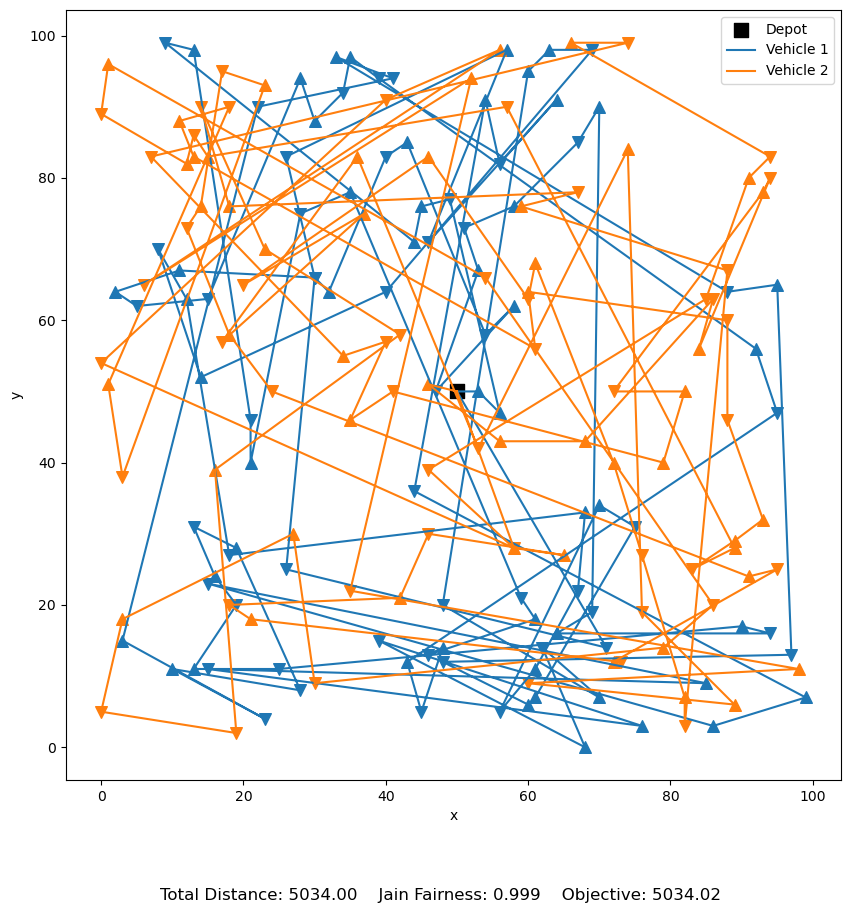

In [114]:
routes = anotherGRASP(instance)
plot_routes(instance, routes)

**Actually, we can see that this GRASP version is much worse than our initial one!!**

## Subtask 8: implement one of the following metaheuristics ... : Simulated Annealing (SA)
We are going to choose Simulated Annealing because we like it. It will probably take some effort to fine-tune it in order to find the best parameters.

In [42]:
instance = Instance("instances/50/train/instance1_nreq50_nveh2_gamma50.txt")
routes = nearest_neighbor_heuristic(instance)
neighborhood = RelocateRandomly(instance)
x = State.from_routes(instance, routes)
next(neighborhood.neighbors(x))

State(routes=((2, 33, 20, 70, 1, 46, 83, 17, 51, 18, 96, 50, 68, 47, 67, 16, 52, 10, 97, 32, 60, 82, 6, 56, 14, 100, 39, 64, 49, 89, 27, 66, 77, 12, 11, 62, 42, 92, 35, 99, 19, 69, 25, 61, 45, 95, 23, 75, 38, 85, 73, 88), (3, 8, 53, 31, 58, 15, 21, 81, 28, 65, 29, 78, 13, 79, 5, 71, 4, 63, 54, 48, 98, 40, 34, 90, 24, 84, 44, 94, 7, 57, 36, 86, 55, 26, 74, 41, 91, 22, 72, 9, 59, 37, 30, 87, 43, 80, 76, 93)), served=frozenset({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}), unserved=frozenset({0}), score=2194.1235473229895)

In [41]:
def simulated_annealing(instance, routes, T_init, alpha=0.95, max_it = 100):
    x = State.from_routes(instance, routes)
    i = 0
    t = 0
    T = T_init
    last_improvements = deque(maxlen=100) # 1000
    last_improvements.append(True)
    scores = []  # Collect scores in each 1000-iteration block
    print("starting SA")
    while any(last_improvements) and T > 1 and i < max_it:
        i += 1
        accepted_random_moves = 0
        block_scores = []  # Scores for this block
        while t < 100:
            neighborhood = RelocateRandomly(instance)
            random_neighbour = next(neighborhood.neighbors(x))
            diff = abs(random_neighbour.score - x.score)
            if random_neighbour.score < x.score:
                x = random_neighbour
                last_improvements.append(True)
            else:
                if random.random() < math.exp(-abs(random_neighbour.score - x.score) / T):
                    x = random_neighbour
                    accepted_random_moves += 1
                last_improvements.append(False)
            block_scores.append(x.score)  # Record score after each move
            t += 1

        # Compute stats after 100 inner iterations
        best_score = min(block_scores)
        worst_score = max(block_scores)
        mean_score = sum(block_scores) / len(block_scores)
        print(f"Acceptance of random moves: {accepted_random_moves / 10} %, Temperature: {T}")
        print(f"Best score: {best_score:.4f}, Worst score: {worst_score:.4f}, Mean score: {mean_score:.4f}")
        T = alpha * T
        t = 0
    return x.routes

initial objective_score =  3821.7317828479413
starting SA
Acceptance of random moves: 0.2 %, Temperature: 15
Best score: 3805.7227, Worst score: 3835.4926, Mean score: 3818.6705
Acceptance of random moves: 0.2 %, Temperature: 14.25
Best score: 3825.8450, Worst score: 3850.8563, Mean score: 3826.3161


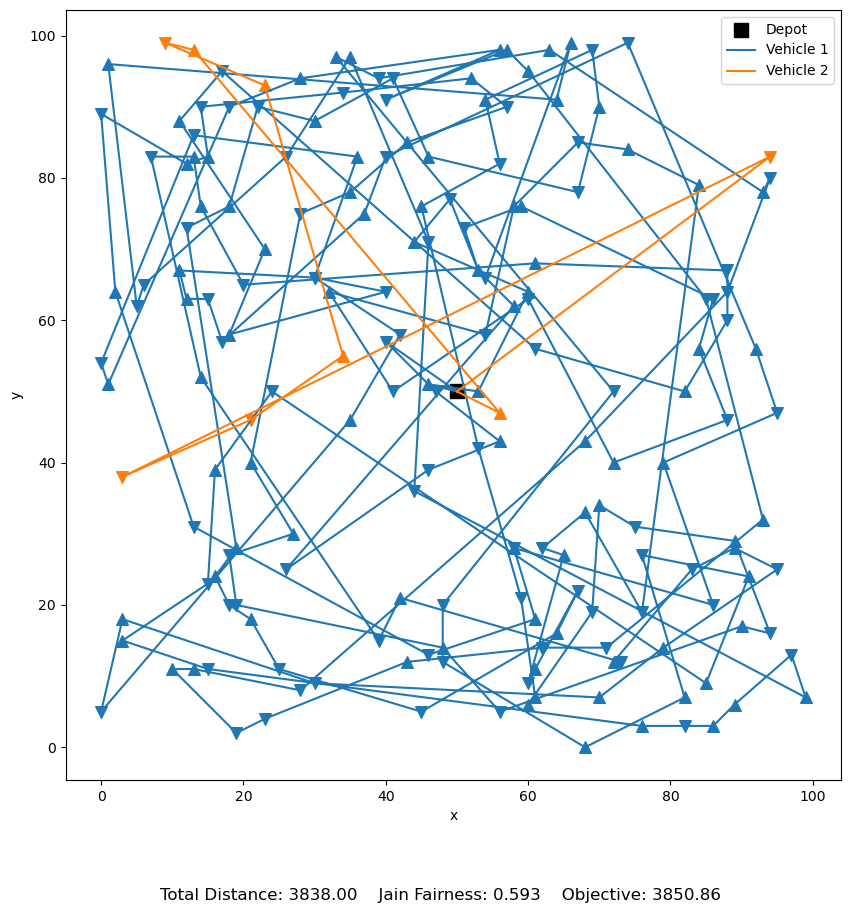

In [48]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
#routes = nearest_neighbor_heuristic(instance)
routes = beam_search(instance, 50)
print("initial objective_score = ", objective_function(instance, routes))
routes = simulated_annealing(instance, routes, 15, alpha = 0.95, max_it=20)
plot_routes(instance, routes)

## Subtask 9: Use delta evaluation
Meaning: instead of recompiling an entire function, e.g. the objective function, we only compute the difference the change causes, and add/subtract this value. So let's start by designing a delta evaluated objective function. The delta objective function was moved up to the other delta evaluation, so that it is defined before it is called :)

However, from our (limited) testing experience, delta evaluation is not always faster.

Furthermore, we are asked: Is it possible to pre-process an instance and use derived information later more efficiently?
Anwser: Yes, by precomputing a distance matrix between all pickup, dropoff, and depot locations, as well as caching route distance sums and squared sums, we can later evaluate routes and delta-objectives more efficiently without recalculating distances repeatedly. However, since we want to focus on experimental tuning right now, we didn't implement this

## Subtask 10: Experimental manual tuning
Now we are asked to perform some experimental manual tuning of relevant algorithmic parameters to find sensible parameter settings for your final experiments. We mainly want to find the best hyperparamters for the Simulated Annealing, namely the initial Temperature T as well as the cooling Schedule variable alpha. For this, We suggest a grid search over the parameter range T = [5, 10, 15, 20, 25, 30] as well as alpha = [0.9, 0.95, 0.98, 0.99]. For each run of the algorithm, we save the time, the final score (objective function, as well as jain fairness).

In [40]:
# Parameter ranges
T_values = [5, 10, 15, 20, 25, 30]
alpha_values = [0.9, 0.95, 0.98, 0.99]


# Output CSV file
output_file = "sa_grid_search_results.csv"

# Prepare CSV header
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["T_init", "alpha", "runtime_sec", "final_objective", "final_jain_fairness"])

# Grid search loop
for T_init in T_values:
    for alpha in alpha_values:
        print(f"Running SA with T_init={T_init}, alpha={alpha}")
        # Start timer
        start_time = time.time()

        # Run SA
        initial_routes = nearest_neighbor_heuristic(instance)
        final_routes = simulated_annealing(instance, initial_routes, T_init, alpha)

        # End timer
        end_time = time.time()
        runtime = end_time - start_time

        # Compute final scores
        final_obj = objective_function(instance, final_routes)
        final_jain = get_Jain_fairness(instance, final_routes)

        # Save to CSV
        with open(output_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([T_init, alpha, runtime, final_obj, final_jain])

        print(f"Done: runtime={runtime:.2f}s, objective={final_obj:.4f}, Jain={final_jain:.4f}\n")

Running SA with T_init=5, alpha=0.9
Acceptance of random moves: 2.4 %, Temperature: 5
Best score: 2230.8971, Worst score: 4094.0286, Mean score: 2622.4740
Acceptance of random moves: 0.8 %, Temperature: 4.5
Best score: 2047.4533, Worst score: 2249.5752, Mean score: 2109.7267
Acceptance of random moves: 0.1 %, Temperature: 4.05
Best score: 2022.4544, Worst score: 2047.4533, Mean score: 2033.3634
Acceptance of random moves: 0.4 %, Temperature: 3.645
Best score: 1985.1780, Worst score: 2037.7563, Mean score: 2009.3210
Acceptance of random moves: 0.3 %, Temperature: 3.2805
Best score: 1922.0117, Worst score: 1985.1780, Mean score: 1948.9736
Acceptance of random moves: 0.1 %, Temperature: 2.9524500000000002
Best score: 1892.3974, Worst score: 1922.0117, Mean score: 1909.1751
Acceptance of random moves: 0.2 %, Temperature: 2.6572050000000003
Best score: 1892.3974, Worst score: 1893.3364, Mean score: 1892.7940
Acceptance of random moves: 0.2 %, Temperature: 2.3914845000000002
Best score: 1818

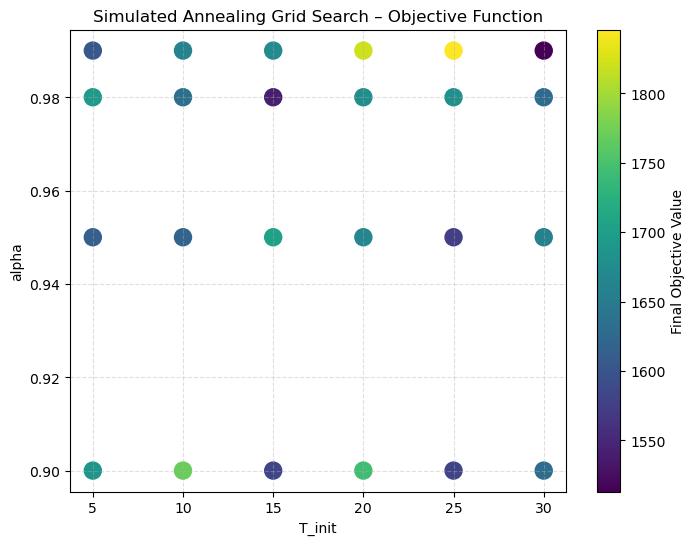

In [42]:
# Load CSV
df = pd.read_csv("sa_grid_search_results.csv")

# Plot objective function as scatter over the grid
plt.figure(figsize=(8, 6))
plt.scatter(df["T_init"], df["alpha"], s=150, c=df["final_objective"])
plt.colorbar(label="Final Objective Value")

plt.xlabel("T_init")
plt.ylabel("alpha")
plt.title("Simulated Annealing Grid Search – Objective Function")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

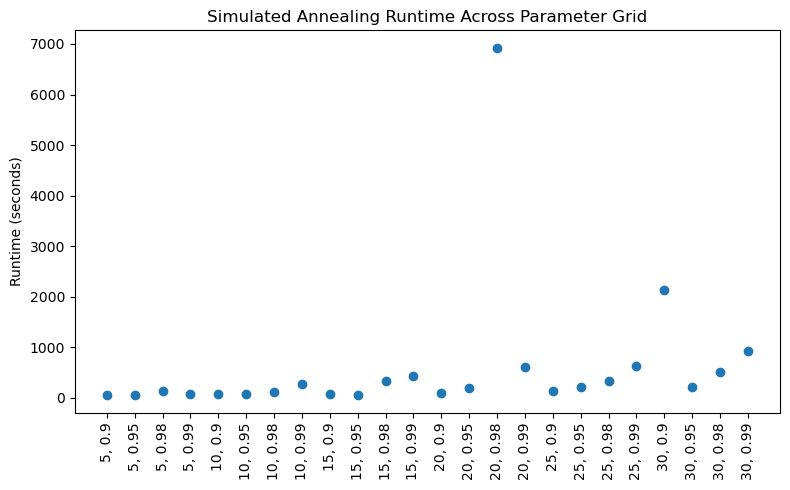

In [43]:
# Plot runtime
plt.figure(figsize=(8,5))
plt.scatter(range(len(df)), df["runtime_sec"])
plt.xticks(range(len(df)), df["T_init"].astype(str) + ", " + df["alpha"].astype(str), rotation=90)
plt.ylabel("Runtime (seconds)")
plt.title("Simulated Annealing Runtime Across Parameter Grid")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Simulated Annealing Runtime Across Parameter Grid, outlier removed')

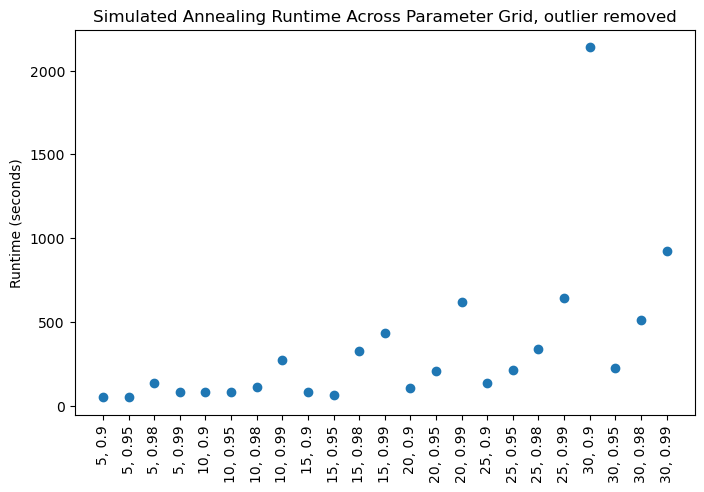

In [44]:
df_clean = df[~((df["T_init"] == 20) & (df["alpha"] == 0.98))]
plt.figure(figsize=(8,5))
plt.scatter(range(len(df_clean)), df_clean["runtime_sec"])
plt.xticks(range(len(df_clean)), df_clean["T_init"].astype(str) + ", " + df_clean["alpha"].astype(str), rotation=90)
plt.ylabel("Runtime (seconds)")
plt.title("Simulated Annealing Runtime Across Parameter Grid, outlier removed")

## Subtask 11: More experiments
The problem is, the instances in the different folders have all widely differnet gamma values, so it does not really make sense to compare them. Let's instead compare the instances for fixed n with varying gamma. So let's chose n = 100 and test our instances for varying gammas. You can easily change the algorithm in the folliwng code to test different alogrithms, I didn't do it in different cells after each other in order not to bloat the notebook.

In [62]:
    folder = f"instances/1000/test" # change folder to test differnt n's
    files = glob.glob(os.path.join(folder, "*.txt"))
    files.sort()
    rows = []

    for file in files:
        instance = Instance(file)
        start_time = time.time()
        solution = randomized_nearest_neighbor_heuristic(instance, 0.5)
        runtime = time.time() - start_time

        rows.append({
            "n": instance.n,
            "gamma": instance.gamma,
            "objective": objective_function(instance, solution),
            "runtime": runtime
        })

    df = pd.DataFrame(rows)
    df.to_csv("results_100.csv", index=False)

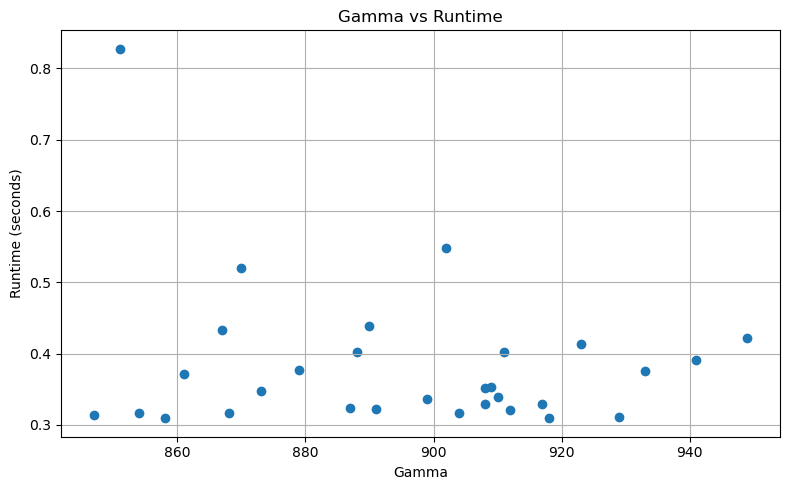

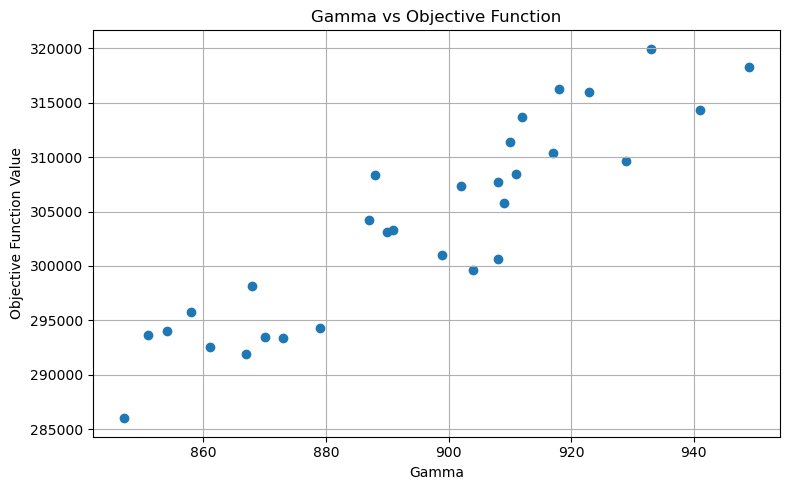

In [63]:
df = pd.read_csv("results_100.csv")

# --- Plot: Gamma vs Runtime ---
plt.figure(figsize=(8, 5))
plt.scatter(df["gamma"], df["runtime"])
plt.xlabel("Gamma")
plt.ylabel("Runtime (seconds)")
plt.title("Gamma vs Runtime")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Gamma vs Objective Function ---
plt.figure(figsize=(8, 5))
plt.scatter(df["gamma"], df["objective"])
plt.xlabel("Gamma")
plt.ylabel("Objective Function Value")
plt.title("Gamma vs Objective Function")
plt.grid(True)
plt.tight_layout()
plt.show()

# Creating the solution files
Now we actually want to create solution files we can submit to tuwel

In [127]:
def save_solution(instance_file_path, routes, output_dir="solutions"):
    """
    Saves the solution in the required format:
    first line = instance file name (without path & extension)
    next lines = each route (only request indices), space-separated
    """

    # ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # extract instance name
    instance_name = os.path.splitext(os.path.basename(instance_file_path))[0]

    # prepare output file path
    out_file = os.path.join(output_dir, instance_name + "_solution.txt")

    with open(out_file, "w") as f:
        # first line: instance name
        f.write(instance_name + "\n")

        # then each vehicle route, request indices separated with spaces
        for route in routes:
            # route is something like [1, 11, 2, 3, 13, ...]
            line = " ".join(str(r) for r in route)
            f.write(line + "\n")

    print(f"Saved solution to {out_file}")

In [128]:
# Lets generate a solution
relevant_files = ["instances/100/competition/instance61_nreq100_nveh2_gamma91.txt",  "instances/1000/competition/instance61_nreq1000_nveh20_gamma879.txt","instances/2000/competition/instance61_nreq2000_nveh40_gamma1829.txt"]
for file in relevant_files:
    instance = Instance(file)
    solution = nearest_neighbor_heuristic(instance)
    #solution = beam_search(instance, 3)
    save_solution(file, solution, "solutions_deterministic_construction_heuristic")

Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq100_nveh2_gamma91_solution.txt
Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq1000_nveh20_gamma879_solution.txt
Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq2000_nveh40_gamma1829_solution.txt


In [170]:
for file in relevant_files:
    instance = Instance(file)
    solution = beam_search(instance, 50)
    save_solution(file, solution, "solutions_beam_search")

Saved solution to solutions_beam_search/instance61_nreq100_nveh2_gamma91_solution.txt


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7965aadcaa50>>
Traceback (most recent call last):
  File "/home/max/anaconda3/envs/heurOpt/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7965aadcaa50>>
Traceback (most recent call last):
  File "/home/max/anaconda3/envs/heurOpt/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [214]:
neighborhoods = [
    RelocateCompact(instance),
    RelocateFlexible(instance),
    SwapRequests(instance)
]

for file in relevant_files:
    instance = Instance(file)
    routes = nearest_neighbor_heuristic(instance)
    initial = State.from_routes(instance, routes)
    local_optimum = variable_neighborhood_descent(
        initial,
        neighborhoods,
        step_fn=first_improvement,
        max_iter=10
    )
    solution = local_optimum.routes
    save_solution(file, solution, "solutions_VND")

KeyboardInterrupt: 